In [1]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

In [81]:
from dataclasses import asdict
from catppuccin.palette import PALETTE
mpl.style.use("mocha")
colors = asdict(PALETTE.__getattribute__("mocha").colors)

## Базовая работа с изображением

In [3]:
image = cv2.imread('sar_2_color.jpg')

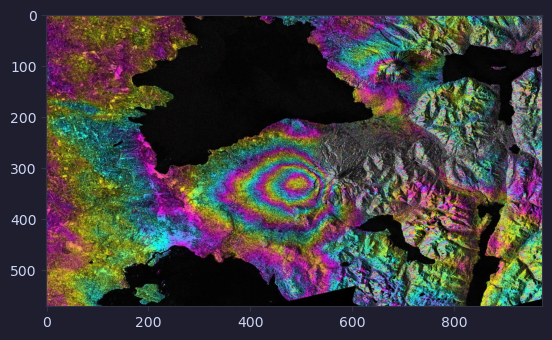

In [4]:
plt.imshow(image)

In [5]:
image.shape # h,w,c

(572, 974, 3)

In [6]:
image[250,250] # b,g,r

array([12, 12, 12], dtype=uint8)

In [7]:
# ROI
img_roi = image[100:200, 500:700]

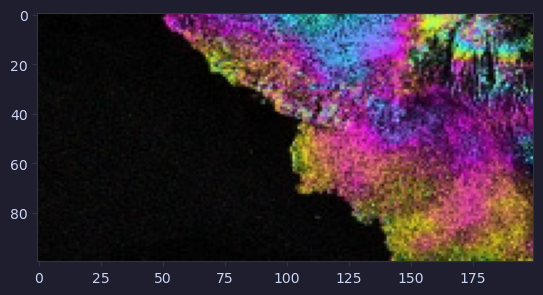

In [8]:
plt.imshow(img_roi)

In [9]:
b,g,r = cv2.split(image)

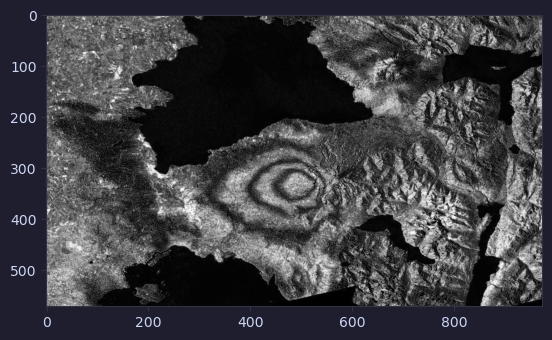

In [10]:
plt.imshow(b, cmap = 'gray')

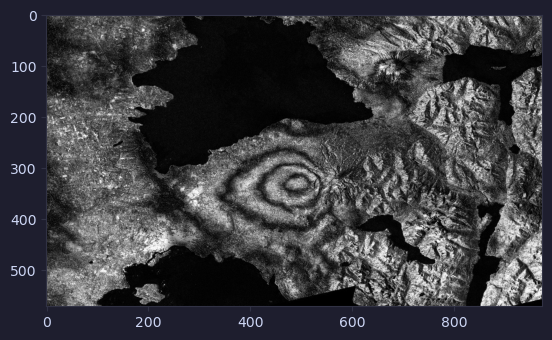

In [11]:
plt.imshow(g, cmap = 'gray')

In [12]:
# alternative approach
b = image[:,:,0]

In [13]:
import copy

image2 = copy.deepcopy(image)

In [14]:
image2[50:100,50:100] = [0,0,0]

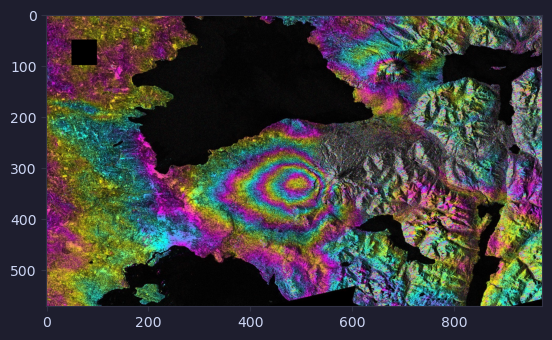

In [15]:
plt.imshow(image2)

In [16]:
# empty image
image_template = np.zeros(image.shape,np.uint8)

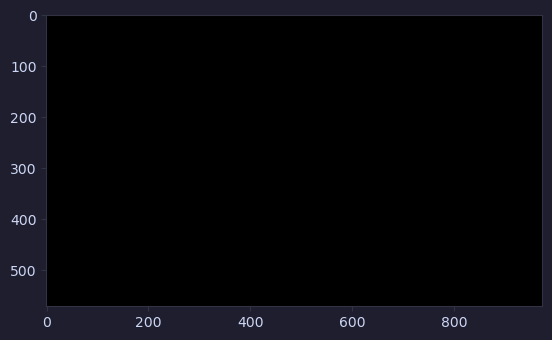

In [17]:
plt.imshow(image_template)

## Конвертация цветовых моделей

In [18]:
image_template[0,0]

array([0, 0, 0], dtype=uint8)

In [19]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

In [20]:
image_gray[0,0]

np.uint8(40)

In [21]:
image_gray.shape

(572, 974)

In [22]:
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 

In [23]:
image_hsv.shape

(572, 974, 3)

In [24]:
image_hsv[0,0]

array([117, 143,  75], dtype=uint8)

In [25]:
image[0,0]

array([75, 37, 33], dtype=uint8)

In [26]:
image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

In [27]:
image_lab[0,0]

array([ 42, 139, 104], dtype=uint8)

## Пороговая фильтрация

In [28]:
_,thresh1 = cv2.threshold(image_gray,200,255,cv2.THRESH_BINARY)

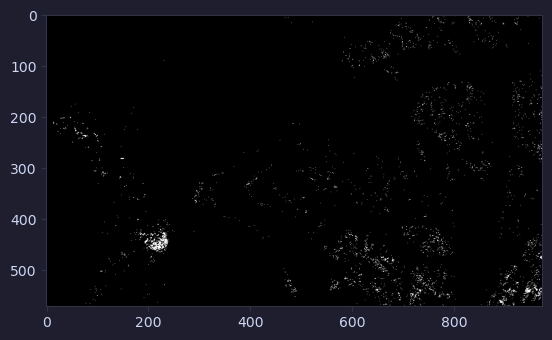

In [29]:
plt.imshow(thresh1, cmap='gray')

In [30]:
thresh1[thresh1==100].sum()

np.uint64(0)

## Построение гистограммы

In [31]:
histSize = 256
histRange = (0, 256)
accumulate = False

b_hist = cv2.calcHist([b], [0], None, [histSize], histRange, accumulate=accumulate)

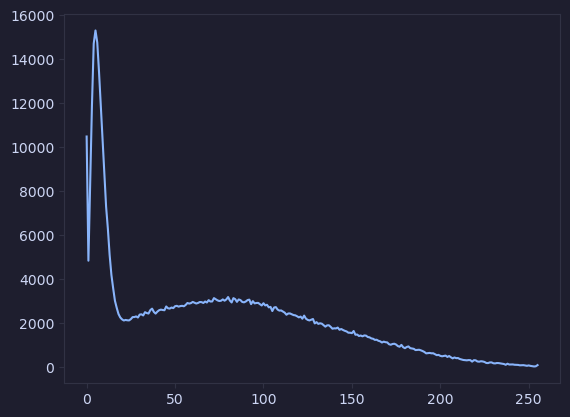

In [32]:
plt.plot(b_hist)

In [33]:
b_hist_cum = b_hist.cumsum()

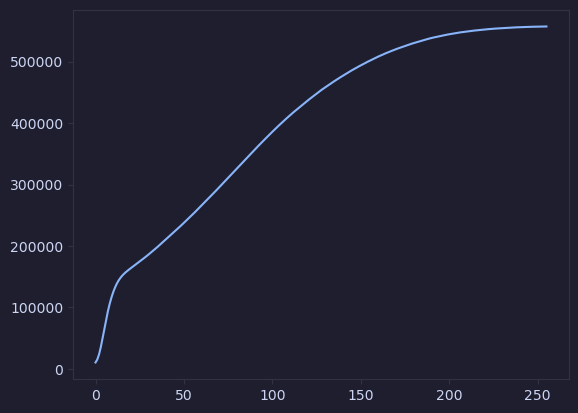

In [34]:
plt.plot(b_hist_cum)

In [35]:
b_hist_norm = b_hist /  (image.shape[0] * image.shape[1])

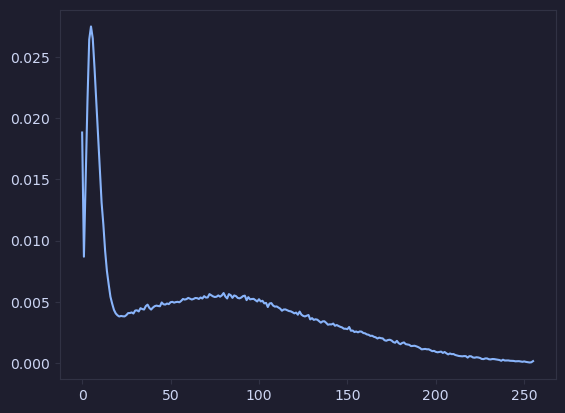

In [36]:
plt.plot(b_hist_norm)

## Сравнение двух изображений

In [37]:
from skimage.metrics import structural_similarity, mean_squared_error

(ssim, diff) = structural_similarity(image_gray, image_gray, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(ssim))

SSIM: 1.0


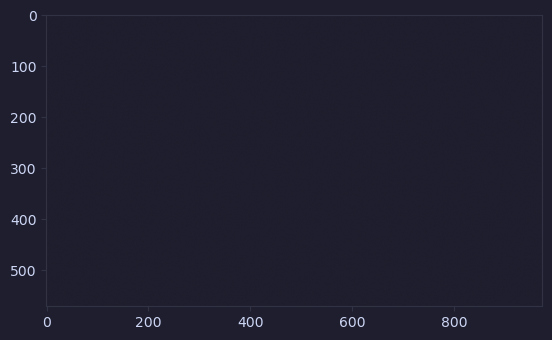

In [38]:
plt.imshow(diff)

In [39]:
mse = mean_squared_error(image_gray, image_gray)
mse

np.float64(0.0)

## Статистические характеристики изображений

In [40]:
mean = image_gray.mean()

In [41]:
std = image_gray.std()

In [42]:
print(mean,std)

67.41225535245043 52.016191875959635


In [43]:
eq_gray = cv2.equalizeHist(image_gray)

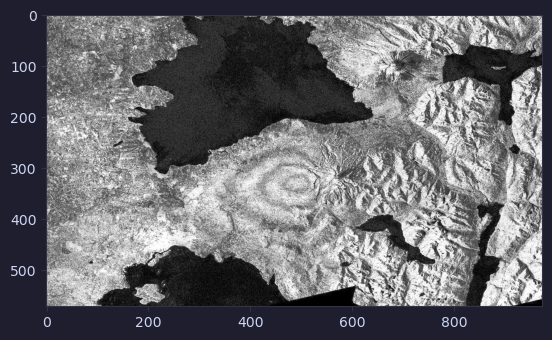

In [44]:
plt.imshow(eq_gray, cmap="gray")


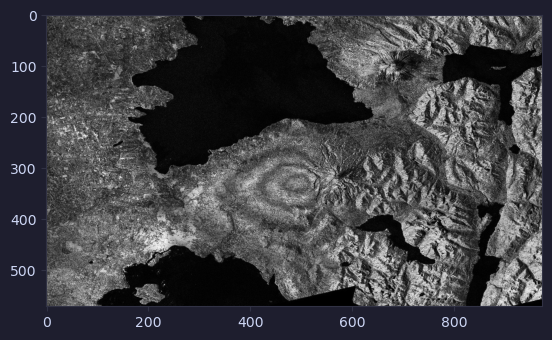

In [45]:
plt.imshow(image_gray, cmap="gray")

# Задание

1. [x] Загрузите изображение в оттенках серого sar_1_gray.jpg. 
2. [x] Постройте гистограмму
3. [x] Реализуйте алгоритм гамма коррекции с параметром гамма <1, >1.
4. [x] Сравните исходное изображение, скорректированное при помощи гамма-фильтра. MSE, SSIM.
5. [ ] Реализуйте алгоритм статистической цветокоррекции на основе статистики eq_gray.
6. [ ] Протестируйте работу алгоритмов пороговой фильтрации с различными параметрами.

Для каждого решения напечатайте результат


## Загрузка

(400, 600)

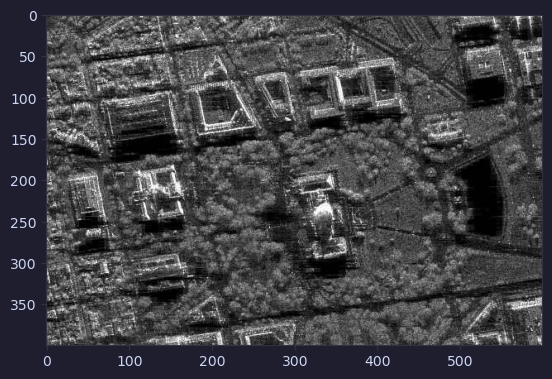

In [87]:
image = cv2.imread('sar_1_gray.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")
image.shape

## Гистограмма

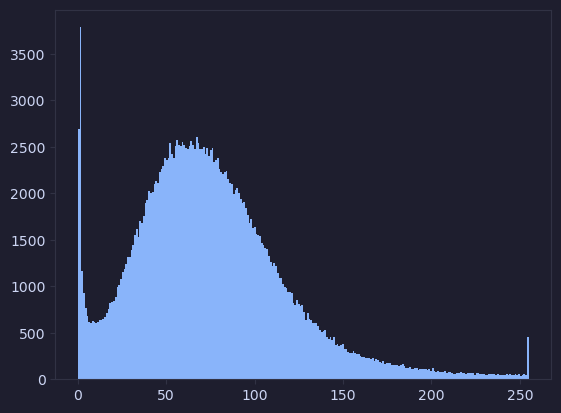

In [70]:
#hist = cv2.calcHist(image, [1], None, [256], (0, 255))
#plt.plot(hist)
_ = plt.hist(image.ravel(), bins=256)

## MSE и SSIM

In [95]:
def mse(img1, img2):
    return np.mean((img1.astype(float) - img2.astype(float)) ** 2)

def ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    
    img1 = img1.astype(float)
    img2 = img2.astype(float)
    
    mu1 = cv2.GaussianBlur(img1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(img2, (11, 11), 1.5)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = cv2.GaussianBlur(img1 ** 2, (11, 11), 1.5) - mu1_sq
    sigma2_sq = cv2.GaussianBlur(img2 ** 2, (11, 11), 1.5) - mu2_sq
    sigma12 = cv2.GaussianBlur(img1 * img2, (11, 11), 1.5) - mu1_mu2
    
    numerator = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)
    
    ssim_map = numerator / denominator
    return np.mean(ssim_map)

## Гамма-коррекция

In [71]:
def gamma_correction(image, gamma):
    image_normalized = image.astype(np.float32) / 255.0
    corrected = np.power(image_normalized, gamma)
    return (corrected * 255).astype(np.uint8)

### <1

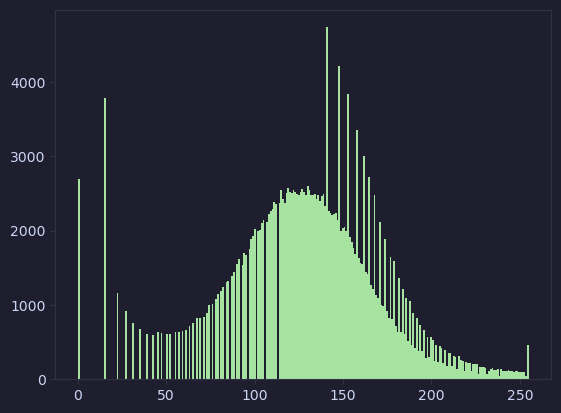

In [94]:
image_gamma = gamma_correction(image, .5)
_ = plt.hist(image_gamma.ravel(), bins=256, color=colors['green']['hex'])

In [97]:
print(f"MSE:  ", mse(image, image_gamma))
print(f"SSIM: ", ssim(image, image_gamma))

MSE:   3250.429145833333
SSIM:  0.7826855938698241


### >1

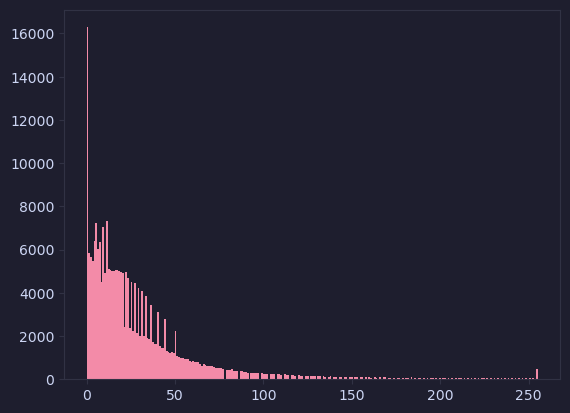

In [98]:
image_gamma = gamma_correction(image, 2.)
_ = plt.hist(image_gamma.ravel(), bins=256, color=colors['red']['hex'])

In [99]:
print(f"MSE:  ", mse(image, image_gamma))
print(f"SSIM: ", ssim(image, image_gamma))

MSE:   2383.7636375
SSIM:  0.5193678832134501
